In [1]:
using Distributions
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!
using Base.Iterators: repeated, partition
using LinearAlgebra: norm
using CounterfactualExplanations
using Distances
using BSON
using MLDatasets

include("../src/utils/train.jl")
include("../src/utils/plot.jl")
include("../src/utils/evaluate.jl")

evaluate_model (generic function with 1 method)

In [2]:
X, y = load_mnist()
X = (X .+ 1) ./ 2

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [3]:
X = reshape(X, 28, 28, 1, 60000)

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [4]:
X

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [87]:
size(X)

(28, 28, 1, 60000)

In [113]:
X_basic, y_basic = TaijaData.load_mnist()
X_basic = (X_basic .+ 1) ./ 2
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]
X_sample = X_basic[:, 100:105]
y_sample = y_basic[100:105]
y_onehot = onehotbatch(y_sample, 0:9)
logits = m(X_sample)

10×6 Matrix{Float32}:
 -13.0563   -4.86521   -5.03296  -17.0138    -8.03976  -17.0315
   4.4687   -5.77479   -9.36942    4.96197   -6.15806    4.63923
  -4.83426  -5.55197   -6.35078   -6.83006   -5.06681   -5.93829
  -4.91434  -3.09782   -7.07591   -6.95062   -3.60399   -7.98563
  -4.0588   -4.56057   -3.33657   -6.04125   -6.34522   -3.98719
  -9.64113   1.38537   -4.37935   -4.28074   -7.73571   -4.02607
 -12.9809   -0.58668  -12.2274    -5.41573  -23.3105    -5.18525
  -3.27705  -4.66463    3.06567   -5.13776    4.11864   -4.39424
  -5.11523  -1.04644   -6.28792   -1.91478   -8.0192    -3.39172
  -6.08031  -1.41937   -2.47942   -6.61189   -1.93297   -5.38134

In [86]:
function margin_loss(logits, y)
    y = onehotbatch(y, 0:9) 
    preds_correct_class = sum(logits.*y, dims=1)
    diff = preds_correct_class .- logits
    diff[y] .= Inf
    margin = minimum(diff, dims=1)
    return margin
end

function cross_entropy_loss(logits, y)
    return -sum(onehotbatch(y, 0:9) .* logsoftmax(logits; dims=1); dims=1)
end

cross_entropy_loss (generic function with 1 method)

In [89]:
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]
X_lol = X[:, :, :, 1:10]
y_lol = y[1:10]
logits = clean_m(reshape(X_lol, 784, 10))

println("logits: ", logits)
println("ce loss: ", cross_entropy_loss(logits, y_lol))
println("margin loss: ", margin_loss(logits, y_lol))

logits: Float32[-26.170753 31.378891 -27.680628 -15.838683 -31.3577 -12.63718 -36.5283 -31.254211 -26.741137 -17.33896; -23.563032 -10.344516 -15.137822 13.657171 -16.317877 -17.669044 17.936192 -21.091835 8.741701 -19.283636; -4.8097744 1.9068854 2.5533426 -3.3486104 -14.112518 20.412117 -10.196568 -13.447754 -18.264563 -11.7307825; 15.041891 -16.716372 -6.262081 -12.69317 -15.019819 -5.8372993 -9.691797 25.451984 -9.267794 -21.103752; -71.854164 -37.13643 13.016738 -12.004934 -0.047304623 -8.565722 -1.2972424 -60.344498 -3.7847438 31.155903; 23.925104 -14.0368805 -20.98747 -26.164425 -20.19985 -17.820028 -20.53177 -15.240777 -12.191358 -12.75583; -42.003765 -1.9879234 -18.965178 -24.142038 -33.72023 -14.109439 -26.10542 -67.39062 -14.759106 -13.616317; -27.129261 -14.350296 -4.216705 -5.647219 -4.40501 -5.9308352 -12.48308 -21.093155 -5.8086824 -11.235661; -21.158636 -13.291356 -6.7286797 -4.9850197 -7.7005806 -2.8785834 -0.16144314 -13.180608 -5.456311 -12.92485; -17.104877 -7.28998

In [85]:
include("../src/utils/attacks.jl")

x_best, n_queries = SquareAttack(clean_m, X_lol, y_lol, 1000, 0.8, 0.3, 0, 1)

784
loss: Float32[0.0110297045 7.152555f-7 15.402267 1.4684806 11.415459 0.00011252724 2.0812283 3.576278f-7 7.931163 9.871343]
index improved size: [8]
0
times_it_actually_improved: 8


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3; … ; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0;;;; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3; … ; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0], [1001.0, 1001.0, 1.0, 1.0, 1.0, 1001.0, 1.0, 1001.0, 1.0, 1.0])

In [58]:
n_queries

10-element Vector{Float64}:
 1001.0
 1001.0
    1.0
    1.0
    1.0
 1001.0
    1.0
 1001.0
    1.0
    1.0

In [59]:
x_topass = reshape(x_best, 784, 10)
logits = clean_m(x_topass)

10×10 Matrix{Float32}:
 -28.7649     19.1293    -13.8587   …  -21.3227   -19.5287   -13.0033
 -24.1901    -11.4987    -19.5035      -12.4306    -2.76463  -21.0054
  -0.190298   -3.46187     8.31674       0.36747   -2.03739    9.73484
  12.0118    -23.3908     -7.34819      18.5699     5.12289   -1.71911
 -81.8009    -25.1924     -7.08546     -51.424    -26.1136    -0.13644
  29.3933     -5.91551   -10.3171   …  -14.4949   -11.2812    -7.972
 -40.9377      0.720023   -3.59191     -48.7855   -16.5745    -4.20126
 -27.2802     -0.25073    -6.57071      -8.09616    1.9812    -4.27803
 -37.7596    -15.1118     -1.32216     -10.7468    -3.18583   -9.52272
 -19.5972     -5.63569   -18.9093       -6.66466  -23.3649   -14.4762

In [60]:
y_lol

10-element Vector{Int64}:
 5
 0
 4
 1
 9
 2
 1
 3
 1
 4

Digit predicted by the model for the clean image: 1
Digit predicted by the model for the 
    adversarial image: 1
True label: 1


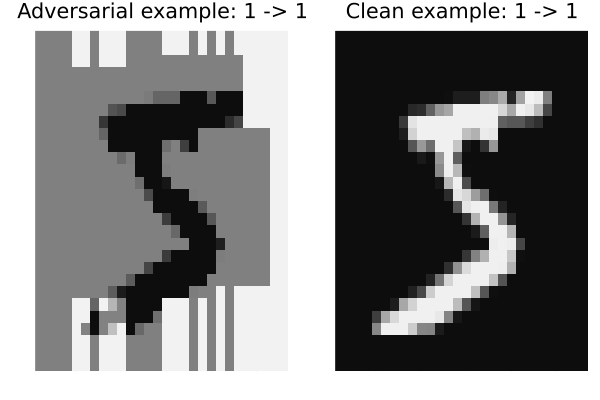

In [79]:
idx = 1
difference = x_best[:, :, :, idx] - X_lol[:, :, :, idx]
plot_mnist_image(difference, X_lol[:, :, :, idx], 1, 1, 1)